<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-iteration/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Implementation

Adpated From: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

## Set up

In [1]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


from torch import Tensor

Machine setup

In [2]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

Hyperparameter setup

In [51]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 5  # number of training epochs
        self.seed = 1234  # randomness seed
        #self.cuda = False  # use nvidia gpu
        #self.img_size = 256  # image shape
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"

In [52]:
train_config = Hparams()

Directory setup

In [7]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')

In [8]:
autoencoder_dir = "./weights/autoencoder.pkl"
# segmentation_autoencoder_dir = "./weights/autoencoder.pkl"

## Data

In [48]:
def EurosatDataloader(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), ])
    trainset = torchvision.datasets.EuroSAT(root='./data',
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    print("[LOG] Size of the image is: {}".format(trainset[0][0].shape))         
    print("[LOG] Total number of batches in the dataloader: %d" %len(trainloader))
    print("[LOG] Total number of images: {}".format(len(trainset)))
    return trainloader

In [49]:
# batch_size = 16

In [53]:
trainloader = EurosatDataloader(batch_size = train_config.batch_size)

[LOG] Size of the image is: torch.Size([3, 64, 64])
[LOG] Total number of batches in the dataloader: 1688
[LOG] Total number of images: 27000


### Plot images

In [12]:
def imshow(img):
    fig, ax = plt.subplots(1, figsize=(20,20))
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
)

GroundTruth:  River River Highway PermanentCrop River PermanentCrop AnnualCrop Residential River HerbaceousVegetation Pasture River HerbaceousVegetation SeaLake PermanentCrop PermanentCrop


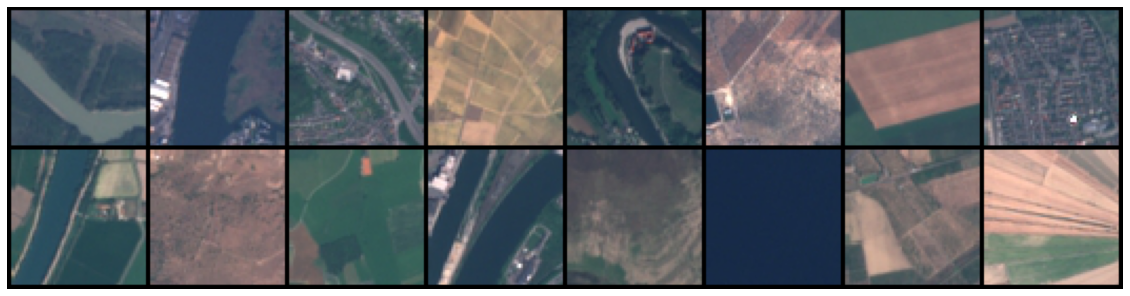

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

## Model

In [15]:
# !pip install pytorch_lightning

In [16]:
# !pip install lightning-bolts

In [17]:
# import pytorch_lightning as pl
# pl.seed_everything(1234)
# from torch import nn
# import torch
# # from pl_bolts.models.autoencoders.components import (
# #     resnet18_decoder,
# #     resnet18_encoder,
# # )

ResNet18 Script: \\
Encoder copied from https://github.com/Lightning-AI/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py \\
Decoder copied from https://github.com/Lightning-AI/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py 

In [18]:
class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate."""

    def __init__(self, size=None, scale_factor=None):
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor)

In [19]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [20]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [21]:
def resize_conv3x3(in_planes, out_planes, scale=1):
    """upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes))

In [22]:
def resize_conv1x1(in_planes, out_planes, scale=1):
    """upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes))

In [23]:
class EncoderBlock(nn.Module):
    """ResNet block, copied from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35."""

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [24]:
# EncoderBlock.expansion

In [25]:
class DecoderBlock(nn.Module):
    """ResNet block, but convs replaced with resize convs, and channel increase is in second conv, not first."""

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

In [26]:
class ResNetEncoder(nn.Module):
    def __init__(self, block, layers,input_dim):
        super().__init__()

        self.inplanes = 64
        self.input_dim = input_dim
        self.conv1 = nn.Conv2d(self.input_dim, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Sequential()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)
        return x

In [27]:
model_encoder = ResNetEncoder(EncoderBlock, [2, 2, 2, 2],input_dim = 3)

In [28]:
from torchsummary import summary
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_encoder = model_encoder.to(device)
summary(model_encoder,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
     EncoderBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [29]:
import torchvision.models as models

# compare with the Pytorch resnet18 model
model_test = models.resnet18(pretrained = False)
model_test = model_test.to(device)
summary(model_test,(3,64,64))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [30]:
class ResNetDecoder(nn.Module):
    """Resnet in reverse order."""

    def __init__(self, block, layers, latent_dim, input_height,output_dim):
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)
        self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
        self.upscale_factor *= 2
        self.upscale = Interpolate(scale_factor=2)
        self.upscale_factor *= 2
        
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(64 * block.expansion, output_dim, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        return x

In [31]:
def resnet18_encoder():
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2],input_dim = 3)

In [32]:
def resnet18_decoder(latent_dim, input_height):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height,output_dim=3)

In [33]:
# set latent dimension
d = 256

In [34]:
import torchvision.models as models

class VariationalAutoencoder(nn.Module):
    def __init__(self,enc_out_dim = 512,latent_dim=d, input_height=64):
        super().__init__()

        # self.encoder = nn.Sequential(
        #     nn.Linear(3*64*64, d ** 2),
        #     nn.ReLU(),
        #     nn.Linear(d ** 2, d * 2)
        # )

        # self.decoder = nn.Sequential(
        #     nn.Linear(d, d ** 2),
        #     nn.ReLU(),
        #     nn.Linear(d ** 2, 3*64*64),
        #     nn.Sigmoid(),
        # )

        self.encoder = resnet18_encoder()
        # from Lightning to Pytorch version
        #self.encoder = models.resnet18(weights=None)
        #self.encoder.fc = nn.Sequential()
        
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        if train_config.optim == "Adam":
          return torch.optim.Adam(self.parameters(), lr=train_config.lr)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch):
        x = batch
        x = x.float()

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        return x_encoded,x_hat,elbo

In [35]:
# def create_model():
#     autoencoder = VariationalAutoencoder()
#     print_model(autoencoder.encoder, autoencoder.decoder)
#     if torch.cuda.is_available():
#         autoencoder = autoencoder.cuda()
#         print("Model moved to GPU in order to speed up training.")
#     return autoencoder

In [36]:
# def get_torch_vars(x):
#     if torch.cuda.is_available():
#         x = x.cuda()
#     return Variable(x)

In [37]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [38]:
# Create model
# model has been moved to device
autoencoder =  VariationalAutoencoder()
autoencoder.to(device)
print_model(autoencoder.encoder, autoencoder.decoder)

============== Encoder ==============
ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [39]:
# check if model is on cuda
print("Device: ", device)
print("Is model on cuda? ", next(autoencoder.parameters()).is_cuda)

Device:  cuda
Is model on cuda?  True


In [40]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in autoencoder.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 20068993.


In [41]:
# Training and testing the VAE

epochs = train_config.epochs
for epoch in range(0, epochs):
    # Training
    if epoch > 0:  # test untrained net first
        autoencoder.train()
        train_loss = 0
        for y, _ in trainloader:
            y = y.to(device)
            # ===================forward=====================
            loss = autoencoder.training_step(y)[2]
            train_loss += loss.item()
            # ===================backward====================
            autoencoder.configure_optimizers().zero_grad()
            loss.backward()
            autoencoder.configure_optimizers().step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader):.4f}')

====> Epoch: 1 Average loss: 1994.1601
====> Epoch: 2 Average loss: -9442.7617
====> Epoch: 3 Average loss: -10610.0529
====> Epoch: 4 Average loss: -11009.6732
====> Epoch: 5 Average loss: -11179.6332
====> Epoch: 6 Average loss: 2378.7794


KeyboardInterrupt: ignored

In [42]:
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder.state_dict(), autoencoder_dir)

Finished Training
Saving Model...


GroundTruth:  PermanentCrop AnnualCrop Forest AnnualCrop Residential Residential HerbaceousVegetation HerbaceousVegetation Highway Forest AnnualCrop HerbaceousVegetation River Forest SeaLake River


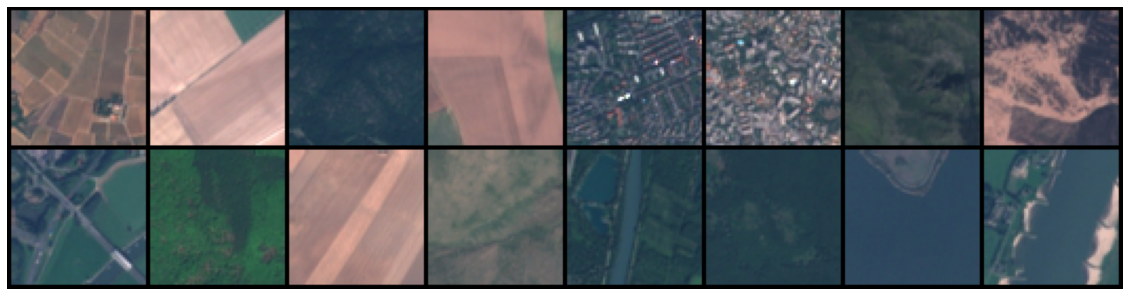

In [43]:
autoencoder.load_state_dict(torch.load(autoencoder_dir))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

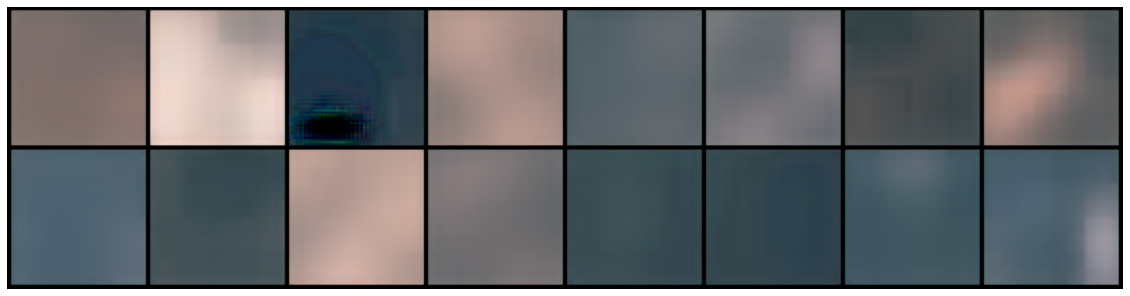

In [54]:
decoded_imgs = autoencoder.training_step(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs))

In [ ]:
# autoencoder.state_dict()